# Evaluation on synthetic data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lib import pipeline
from lib import data_gen
import importlib
import matplotlib
importlib.reload(pipeline)
from mlreflect.models import DefaultTrainedModel, TrainedModel
from mlreflect.data_generation import ReflectivityGenerator
from mlreflect.training import InputPreprocessor, OutputPreprocessor
import tensorflow as tf
from tensorflow import keras
from mlreflect.curve_fitter import CurveFitter
from mlreflect.data_generation import interp_reflectivity
test_number_of_curves = 10240
#test_number_of_curves = 512

test_values_per_curve = 109
PARAMETERS = ["Film_thickness", "Film_roughness", "Film_sld"]
PARAMETERS_PLAIN = ["Thickness", "Roughness", "SLD"]
silver="#BFC0C0"
coral="#4F5D75"

matplotlib.rcParams.update({
    "font.size": 20,
    "boxplot.boxprops.color": "gray",
    "boxplot.patchartist":True,
    "boxplot.showfliers": False,
    "boxplot.notch": False,
    "boxplot.medianprops.color": "firebrick",
    "patch.facecolor": silver
                         })

In [2]:
noise_level=0.3
BATCH_SIZE=256

In [3]:
# model_cnn = keras.models.load_model(
#     'models/current_state_models/0.001_0.2_100_100_50_12_8_512_20220705-194014')
# model_cnn=keras.models.load_model("models/current_state_models/0.0_800.0_25_50_100_10_8_6_512_20220714-124651")
# model_cnn = keras.models.load_model(
#     'models3l/0.1_25_50_75_12_8_4_256_20220719-091356')
model_cnn = keras.models.load_model(
    'models3l/0.3_25_50_75_12_8_4_256_20220812-145510')
mean_labels, std_labels = np.loadtxt(
    "data/mean_labels.csv"), np.loadtxt("data/std_labels.csv")
mean_data, std_data = np.loadtxt(
    f"data/mean_data_{noise_level}.csv"), np.loadtxt(f"data/std_data_{noise_level}.csv")

In [4]:
def predict_mlp_syn(gen_test, ip, out, data_test_true_real_scale):
    reflectivity_true_unit_scale = ip.standardize(data_test_true_real_scale)
    model = DefaultTrainedModel().keras_model
    pred_params_unit_scale = model.predict(reflectivity_true_unit_scale)
    pred_params_real_scale_full = out.restore_labels(pred_params_unit_scale)
    reflectivity_sim = gen_test.simulate_reflectivity(
        pred_params_real_scale_full)
    #print(model.summary())
    return reflectivity_sim, pred_params_real_scale_full

In [5]:
def predict_cnn_syn(generator, reflectivity_true_real_scale, labels):

    reflectivity_true_real_scale = reflectivity_true_real_scale.reshape(
        test_number_of_curves, test_values_per_curve, 1)
    pred_params_true_scale_full = labels.copy()
    
    labels=labels.drop(labels.columns.difference(["Film_thickness", "Film_roughness", "Film_sld"]), axis=1)
    labels=labels.to_numpy()
    dataset=tf.data.Dataset.from_tensor_slices((reflectivity_true_real_scale, labels)).batch(BATCH_SIZE)
    pred_params_unit_scale = model_cnn.predict(dataset)
    pred_params_true_scale = pred_params_unit_scale*std_labels+mean_labels
    
    pred_params_true_scale_full["Film_thickness"] = pred_params_true_scale[:, 0]
    pred_params_true_scale_full["Film_roughness"] = pred_params_true_scale[:, 1]
    pred_params_true_scale_full["Film_sld"] = pred_params_true_scale[:, 2]
    reflectivity_sim = generator.simulate_reflectivity(
        pred_params_true_scale_full)
    #print(model_cnn.summary())
    return reflectivity_sim, pred_params_true_scale_full

In [6]:
def get_mse(params_cnn, params_mlp, labels):
    mse=tf.keras.losses.MeanSquaredError()
    error_dict={}
    for idx, modelname in enumerate(["mlp", "cnn"]):
        
        cnn_parameters=params_cnn[PARAMETERS].to_numpy()
        mlp_parameters=params_mlp[PARAMETERS].to_numpy()
        #MSE errors
        model_params=[cnn_parameters, mlp_parameters]
        labels_parameters=labels[PARAMETERS].to_numpy()
        error_lst = []
        for entry_pred, entry_labels in zip(model_params[idx], labels_parameters):
            entry_pred=(entry_pred-mean_labels)/std_labels
            entry_labels=(entry_labels-mean_labels)/std_labels
            error_lst.append(mse(entry_pred, entry_labels).numpy())
        error_dict[modelname]=error_lst
    return error_dict

In [7]:
def get_log_error(reflectivity_true_real_scale, refl_sim_lst):
    log_error_dict={}
    for model_idx, (sim_lst, modelname) in enumerate(zip(refl_sim_lst, ["mlp", "cnn"])):
        log_error_lst=[]
        for curve_true, curve_sim in zip(reflectivity_true_real_scale, sim_lst):
            log_error_lst.append(pipeline.log_error(curve_sim, curve_true))
        log_error_dict[modelname]=log_error_lst
    return log_error_dict

In [8]:
def make_analysis(reflectivity_true_real_scale, q_values, refl_sim_lst, params_cnn, params_mlp, labels, error_dict, error_dict_log_error):
    np.random.seed(234324)
    fig_boxplot, axs_boxplot = plt.subplots(1)
    fig_boxplot_log_error, axs_boxplot_log_error = plt.subplots(1)
    fig_boxplots_param_errors, axs_boxplots_param_errors = plt.subplots(
        2, 3, figsize=(15, 10))
    fig_curves, axs_curves = plt.subplots(3, 3, figsize=(15, 15),sharex=True, sharey=True)
    
    axs_boxplot.set_ylabel("MSE in a.u.")
    
    #log error boxplot
    log_error_boxplot=axs_boxplot_log_error.boxplot(
        [error_dict_log_error["mlp"], error_dict_log_error["cnn"]], showfliers=False
    )
    for el in log_error_boxplot["medians"]: print(f"log_error error: {el.get_ydata()[0]}")
    axs_boxplot_log_error.set_xticklabels(["MLP", "CNN"])
    axs_boxplot_log_error.set_ylabel("Log-error in a.u.")

    #MSE errors boxplot
    mse_boxplot=axs_boxplot.boxplot(
        [error_dict["mlp"], error_dict["cnn"]], showfliers=False)
    for el in mse_boxplot["medians"]: print(f"mse_error: {el.get_ydata()[0]}")
    axs_boxplot.set_xticklabels(["MLP", "CNN"])

    #Reflectivity Curves (ground truth)
    #shuffle indices
    indices = np.arange(reflectivity_true_real_scale.shape[0])
    np.random.shuffle(indices)
    for modelname, curve_lst in zip(["MLP", "CNN"], refl_sim_lst):
        for curve_idx, (ax, curve_pred) in enumerate(zip(axs_curves.flat, curve_lst[indices])):
            ax.semilogy(q_values, curve_pred, label=f"prediction {modelname}", color="firebrick" if modelname=="CNN" else "gray")
    reflectivity_true_real_scale=reflectivity_true_real_scale[indices]
    for idx, ax in enumerate(axs_curves.flat):
        ax.semilogy(
            q_values, reflectivity_true_real_scale[idx], label="ground truth", color=coral)
    
    for ax in axs_curves[-1,:]:
        ax.set_xlabel("q in $\mathrm{\AA^{-1}}$")
    for ax in axs_curves[:, 0]:
        ax.set_ylabel("Reflectivity")
    for ax in axs_curves.flat:
        ax.legend()
        
    #Absolute errors
    for idx, (box, param) in enumerate(zip(axs_boxplots_param_errors[0,:], PARAMETERS)):
        box_abs=box.boxplot([np.absolute(params_mlp[param]-labels[param]),
                    np.absolute(params_cnn[param]-labels[param])])
        for el in box_abs["medians"]: print(f"absolute error: {el.get_ydata()[0]}")
        if idx==0:
            box.set_title("Film Thickness")
        if idx==1:
            box.set_title("Film Roughness")
        if idx==2:
            box.set_title("Film SLD")    
        
        if idx is not 2:
            box.set_ylabel("Absolute error in $\mathrm{\AA}$")
        else:
            box.set_ylabel("Absolute error in $\mathrm{10^{-6} \AA^{-2}}$")
        box.set_xticklabels(["MLP", "CNN"])
        
    #Relative errors
    for idx, (box, param) in enumerate(zip(axs_boxplots_param_errors[1,:], PARAMETERS)):
        rel_boxplot=box.boxplot([100*np.absolute(params_mlp[param]-labels[param])/labels[param], 100 *
                    np.absolute(params_cnn[param]-labels[param])/labels[param]])
        for el in rel_boxplot["medians"]: print(f"relative error: {el.get_ydata()[0]}")
        box.set_xticklabels(["MLP", "CNN"])
        box.set_ylabel("Relative error in %")

    fig_boxplots_param_errors.tight_layout()
    fig_boxplot.tight_layout()
    fig_boxplot_log_error.tight_layout()
    fig_curves.tight_layout()

    fig_boxplots_param_errors.savefig("../fig/synth_perf/param_errors_synth_comp.pdf")
    fig_boxplot.savefig("../fig/synth_perf/mse_error_synth_comp.pdf")
    fig_boxplot_log_error.savefig("../fig/synth_perf/log_error_synth_comp.pdf")
    fig_curves.savefig("../fig/synth_perf/curves_synth_comp.pdf")


In [9]:
def simulate_and_predict():
    q_values = DefaultTrainedModel().q_values
    sample = DefaultTrainedModel().sample
    generator = ReflectivityGenerator(q_values, sample)
    labels = generator.generate_random_labels(test_number_of_curves)
    ip = InputPreprocessor()
    out = OutputPreprocessor(sample)
    reflectivity_true_real_scale = generator.simulate_reflectivity(labels)
    refl_sim_lst = []
    reflectivity_sim_mlp, params_mlp = predict_mlp_syn(
        generator, ip, out, reflectivity_true_real_scale)
    refl_sim_lst.append(reflectivity_sim_mlp)
    reflectivity_sim_cnn, params_cnn = predict_cnn_syn(
        generator, reflectivity_true_real_scale, labels)
    refl_sim_lst.append(reflectivity_sim_cnn)
    return reflectivity_true_real_scale, q_values, refl_sim_lst, params_cnn, params_mlp, labels

__Simulation__

In [10]:
reflectivity_true_real_scale, q_values, refl_sim_lst, params_cnn, params_mlp, labels=simulate_and_predict()

100%|██████████| 10240/10240 [00:00<00:00, 14841.67it/s]


__Calculate MSE__

In [11]:
error_dict=get_mse(params_cnn, params_mlp, labels)

__Calculate log-error__

In [12]:
error_dict_log_error=get_log_error(reflectivity_true_real_scale, refl_sim_lst)

__Analysis plots__

log_error error: 0.02940657584786497
log_error error: 0.03383586927592898
mse_error: 0.16462304443120956
mse_error: 0.026201628148555756
absolute error: 26.31596754145579
absolute error: 96.86151747316535
absolute error: 2.6153776680504905
absolute error: 9.844969619189909
absolute error: 0.4210785830081921
absolute error: 0.2771484300253704
relative error: 8.34998883389435
relative error: 21.703288242755704
relative error: 10.9662961216636
relative error: 23.98515795109654
relative error: 5.27927059997101
relative error: 3.53468831512458


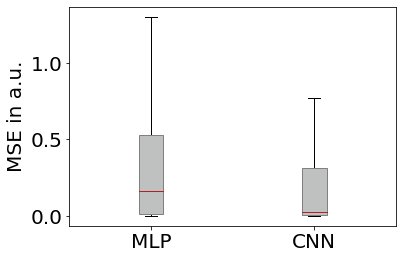

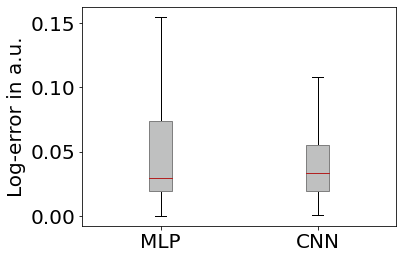

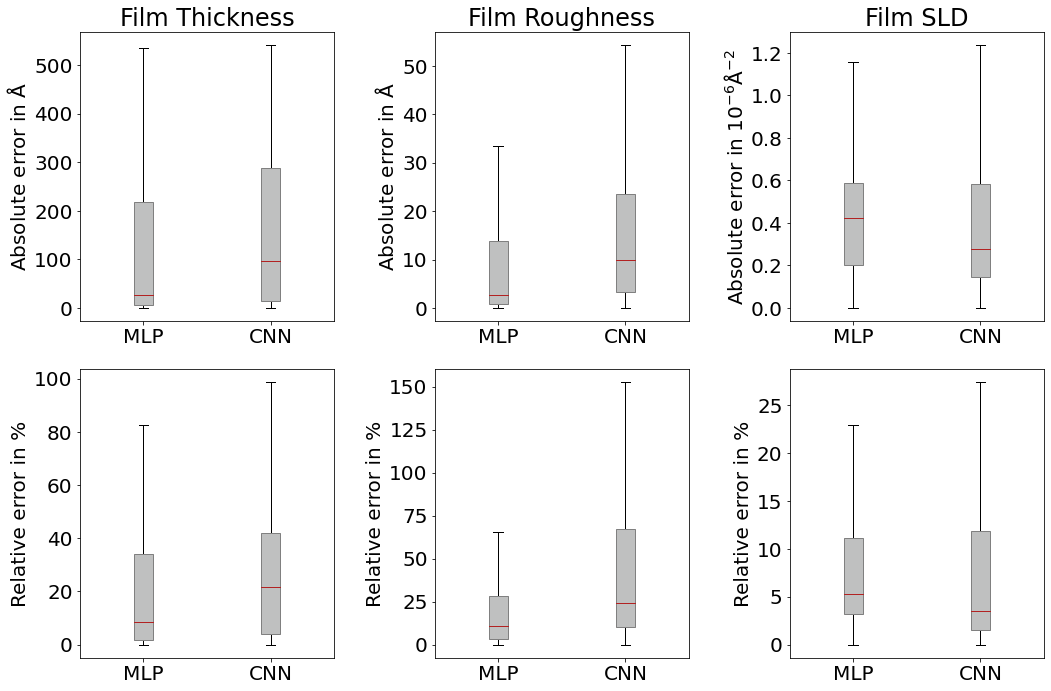

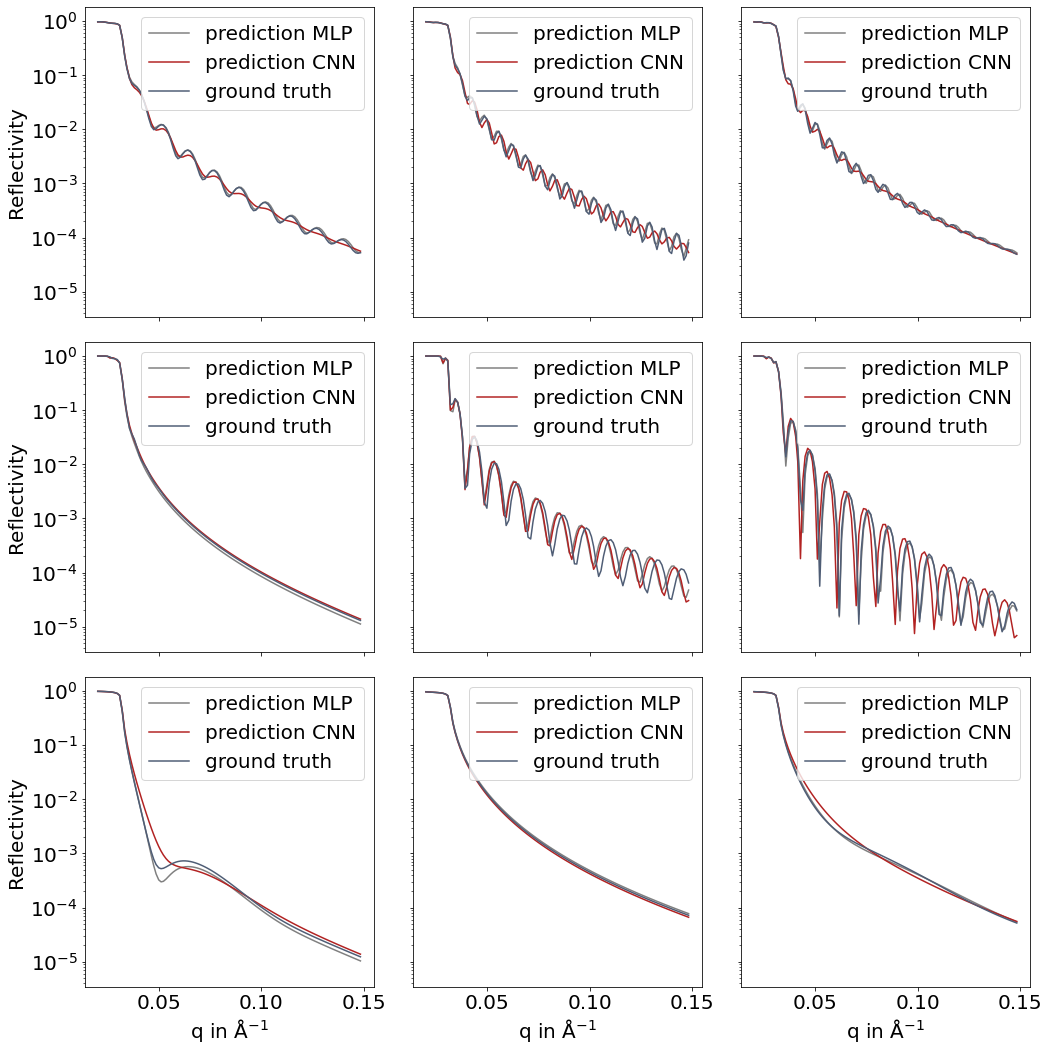

In [13]:
make_analysis(reflectivity_true_real_scale, q_values, refl_sim_lst, params_cnn, params_mlp, labels, error_dict, error_dict_log_error)